# Lecture 20 - Inverse Problems/Model Calibration: Bayesian Approach

## Objectives

+ Demonstrate that classical inverse problems are ill-posed.
+ Formulate inverse problems as Bayesian inference problems.
+ Remember the Laplace approximation.
+ Demonstrate approach by applying it to the calibration of a reaction kinetics problem.
+ Highlight the shortcomings of the Laplace approximation.

## Readings

+ These notes.

In [1]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import design
import warnings
warnings.filterwarnings('ignore')
import orthpol 

# Example 1: Demonstrate that the classical approach does not identify noise

The classical approach does not provide a way to estimate the measurement noise.

      fun: 0.007413777293838574
 hess_inv: array([[  2.06503449e+00,   6.31348287e-01,  -3.02927219e+00,
         -5.13731044e-02,  -5.48551948e-01],
       [  6.31348287e-01,   9.43717043e+00,  -1.00822572e+01,
          2.47306717e+00,   3.54239253e-01],
       [ -3.02927219e+00,  -1.00822572e+01,   2.40958264e+01,
          3.59903818e+00,   1.16933607e+01],
       [ -5.13731044e-02,   2.47306717e+00,   3.59903818e+00,
          2.26415349e+01,   2.58937472e+00],
       [ -5.48551948e-01,   3.54239253e-01,   1.16933607e+01,
          2.58937472e+00,   9.14614101e+01]])
      jac: array([  4.46762336e-07,   1.14177057e-06,   3.56322284e-07,
        -6.12996545e-08,  -9.45887691e-07])
  message: 'Optimization terminated successfully.'
     nfev: 29
      nit: 26
     njev: 29
   status: 0
  success: True
        x: array([ 1.35942991,  1.65881181,  1.3457712 , -0.16052148, -1.0487898 ])


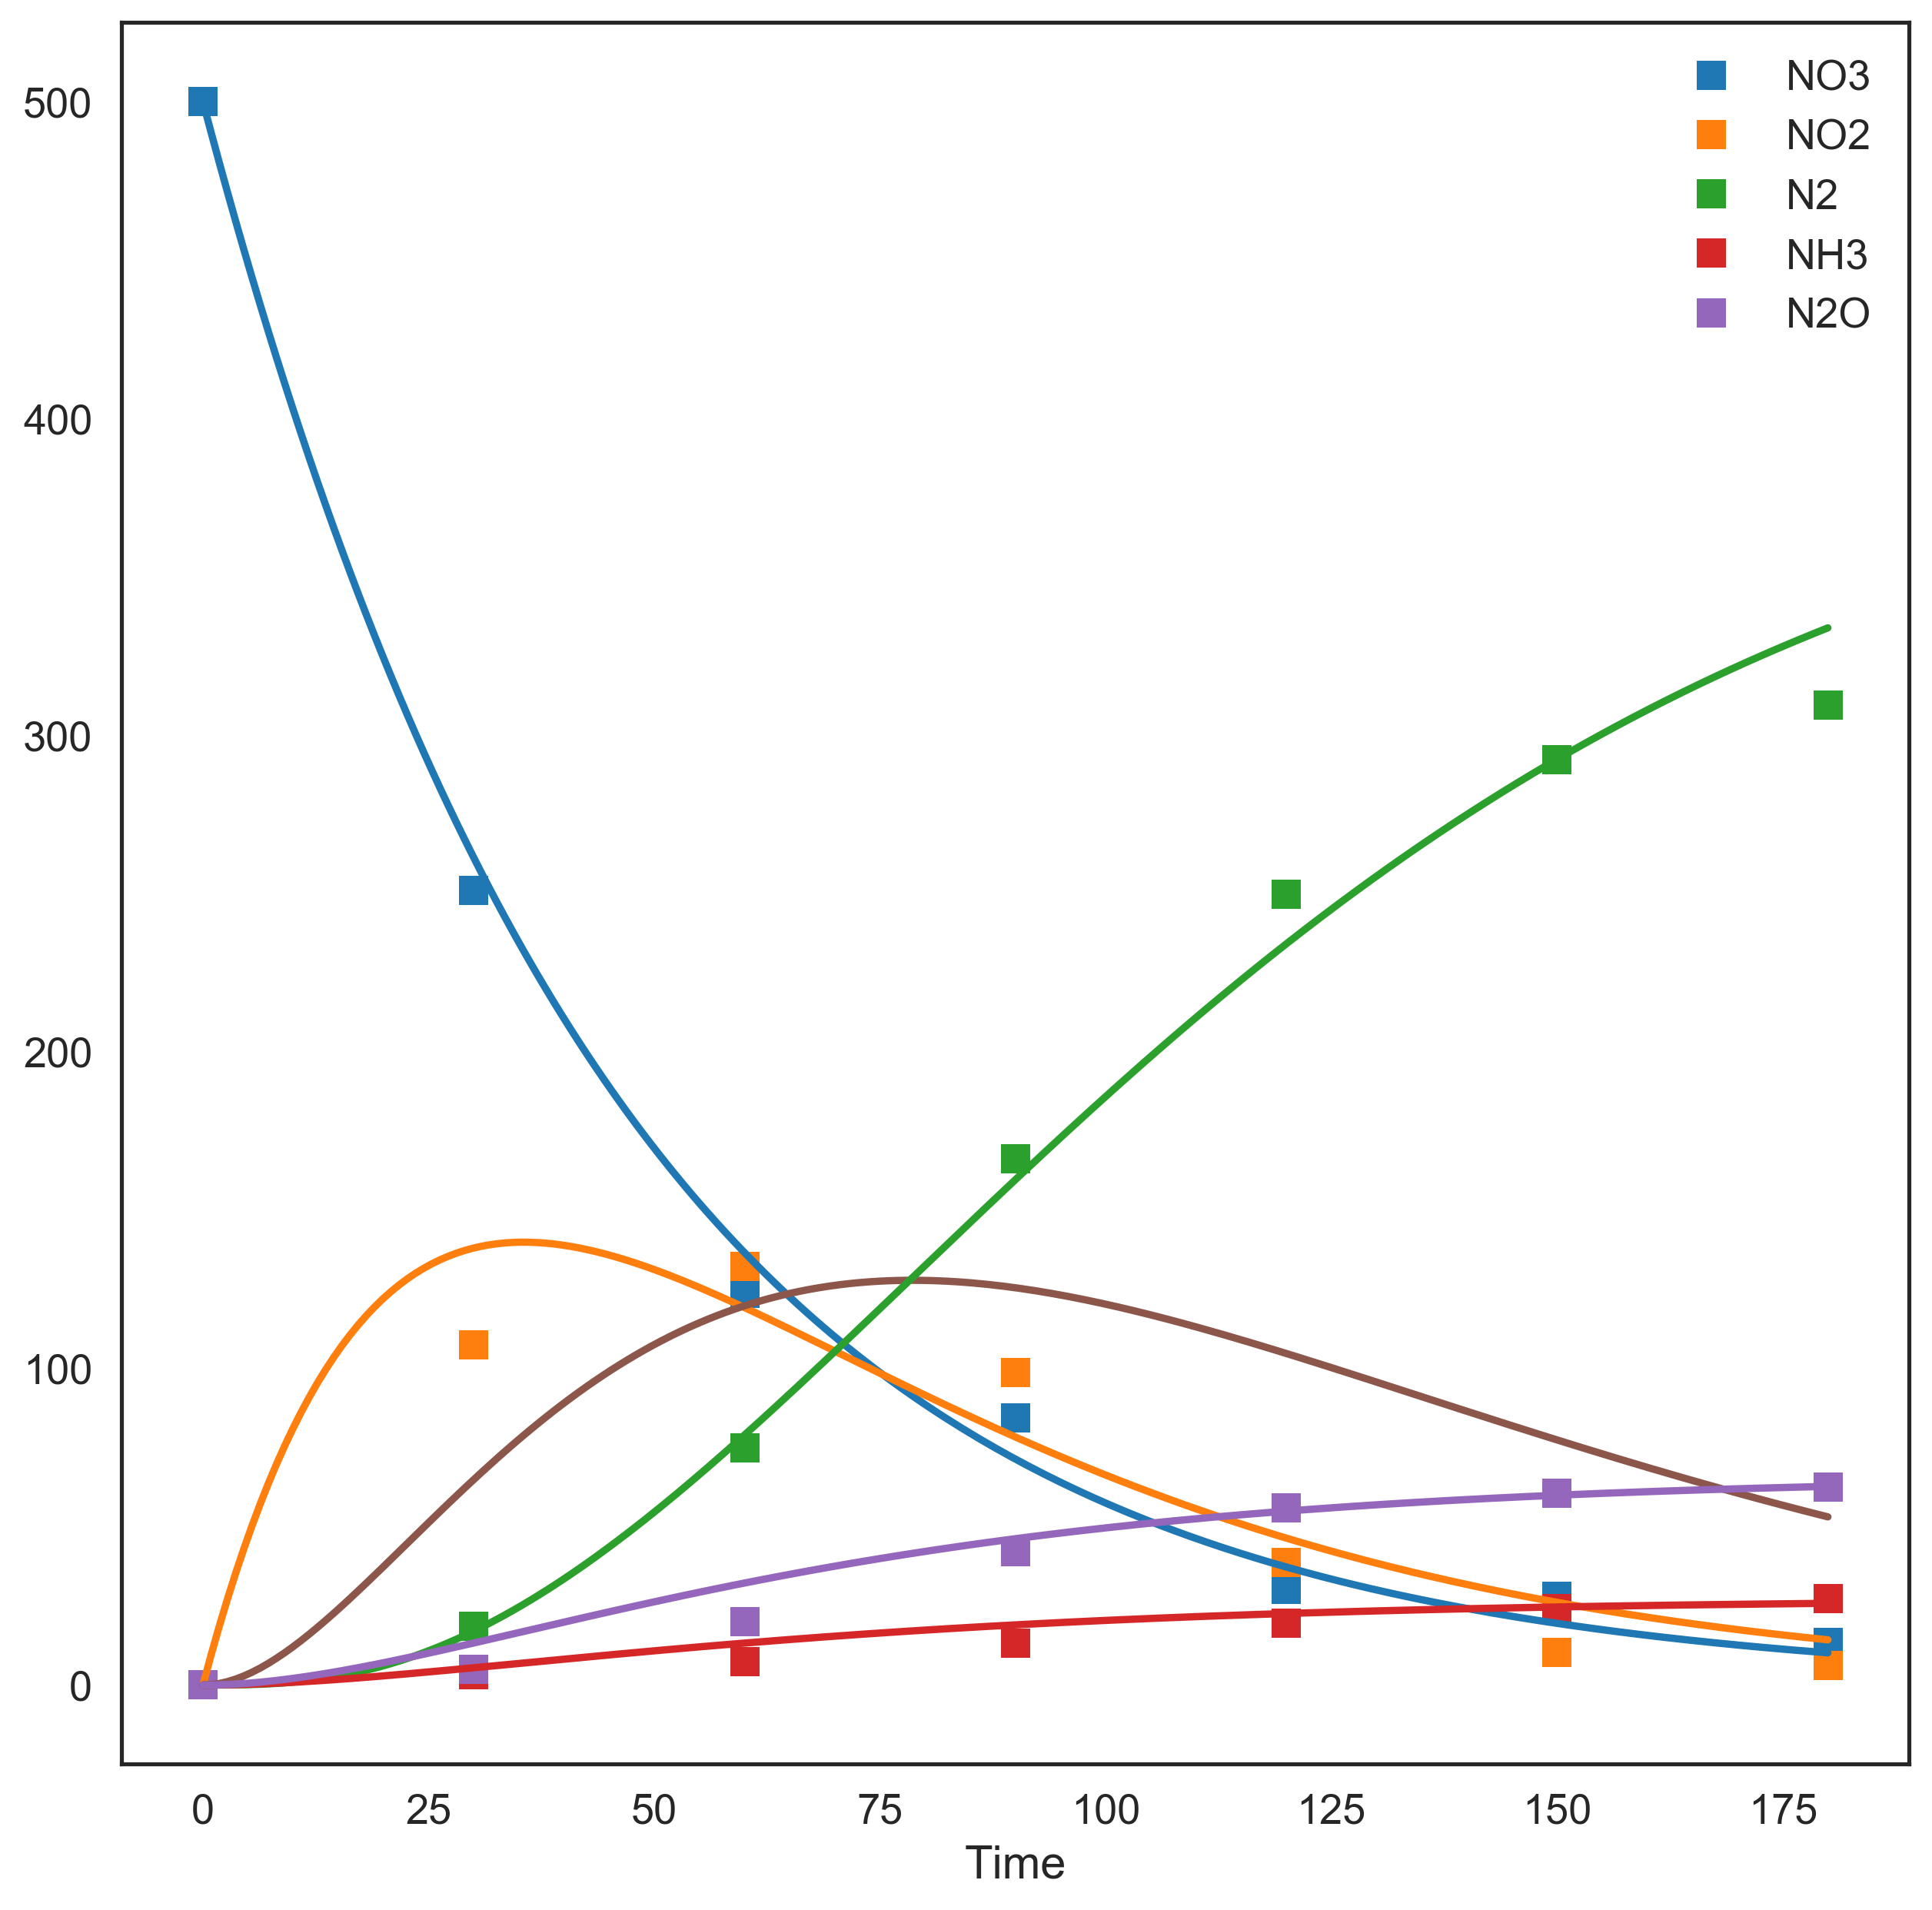

In [2]:
# The data
import pandas as pd
catalysis_data = pd.read_csv('catalysis.csv', index_col=0)

# The experimental data as a matrix
Y = catalysis_data[1:].get_values()

# The experimental as a vector
y = Y.flatten()

# The model
from demos.catalysis import CatalysisModel
solver = CatalysisModel()  


# The loss function
def L_with_jac(x, y):
    k = np.exp(x) / 180.
    sol = solver(k)
    y = y / 500.
    f = sol['f'][0][5:] / 500
    dfdk = sol['f_grad'][0][5:, :] / 500.
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (f - y)
    dLdx = np.einsum('ij,i->j', dfdx, tmp)
    L = 0.5 * np.sum(tmp ** 2)
    return L, dLdx

# For making predictions
import scipy.integrate

def A(x):
    """
    Return the matrix of the dynamical system.
    """
    # Scale back to the k's
    k = np.exp(x) / 180.
    res = np.zeros((6,6))
    res[0, 0] = -k[0]
    res[1, 0] = k[0]
    res[1, 1] = -(k[1] + k[3] + k[4])
    res[2, 1] = k[1]
    res[2, 2] = -k[2]
    res[3, 2] = k[2]
    res[4, 1] = k[4]
    res[5, 1] = k[3]
    return res
    

def g(z, t, x):
    """
    The right hand side of the dynamical system.
    """
    return np.dot(A(x), z)




# The full solution of the dynamical system
def Z(x, t):
    """
    Returns the solution for parameters x at times t.
    """
    # The initial conditions
    z0 = np.array([500., 0., 0., 0., 0., 0.])
    return scipy.integrate.odeint(g, z0, t, args=(x,))


# Initial guess for x
x0 = np.random.randn(5)

# Minimize the loss function
res = scipy.optimize.minimize(L_with_jac, x0, jac=True, args=(y))

print res

# Make predictions
t = np.linspace(0, 180, 200)
Yp = Z(res.x, t)

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
catalysis_data.plot(ax=ax, style='s')
ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], label='Model X')
ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], label='Model N2O')

It looks pretty good, but there is no estimate of uncertainty.

## Other Issues of the Classical Formulation

+ The solution may not exist. (In the catalysis example, try calibrating a model that does not include the intermediate element $X$. It is not possible because the total mass will not be conserved.)

+ Multiple solutions may exist. (In the catalysis example, try adding one more fictitious element product Y. You will probably fit the data very well. But which model is the right one?)

+ No estimate of uncertainty.

## Bayesian Formulation of Inverse Problems

Let us reintroduce everything we had before:

+ $x\in\mathcal{X}\in\mathbb{R}^d$ are the unknown parameters.
+ $y\in\mathcal{Y}\in\mathbb{R}^m$ are the experimental measurements.
+ $f:\mathcal{X}\rightarrow \mathcal{Y}$ is your model.

For the Bayesian approach to inverse problems we need two ingredients:

+ A *prior* probability density for $x$, $p(x)$.

+ A *likelihood model* $p(y|x, f)$.
Typically the form of the likelihood model is:
$$
p(y|x, f) = p(y|f(x)),
$$
and the most common choice is, of course, the Gaussian:
$$
p(y|x,f,\sigma^2) = \mathcal{N}\left(y|f(x), \sigma^2I\right).
$$
Of course, we would like to estimate $\sigma^2$ also.
For this reason, we need to introduce a prior probability density $p(\sigma)$ as well.

**Note:** Remember that the likelihood model is your choice and it should reflect what you know about the noise process.

Let's assume that we have the Gaussian likelihood.
All we need to do now is apply the Bayes rule:
$$
p(x, \sigma^2|y, f) \propto p(y|x,f,\sigma^2)p(x)p(\sigma).
$$
That's it!
This is our *posterior state of knowledge* about all the parameters.
Now the only problem is to characterize this probability density.

### Remarks

+ The Bayesian solution to inverse problems is no longer a point estimate. It is a distribution.

+ The solution always exists.

+ The solution is unique.

+ The probability mass in the posterior automatically quantifies uncertainties.

## The Laplace Approximation
If you have a linear model and a Gaussian likelihood and the prior $p(x)$ is Gaussian, then this is just a Gaussian.
In general, you can only chacterize it through sampling or some approximation.
We will discuss sampling from the posterior in Lecture 21 when we will introduce Markov Chain Monte Carlo.
For now, let us discuss the Laplace approximation to the posterior.

The Laplace approximation finds a Gaussian approximation to the posterior.
For simplicity we will work with a Gaussian likelihood, but these ideas can be applied to any likelihood.
To avoid over complicating things on this first attempt, let us assume that we know the value of $\sigma$.
We will generalize our approach later.
Our posterior is (for just $x$) is:
$$
p(x|y,\sigma) \propto p(y|x,\sigma)p(x) = \mathcal{N}\left(y|f(x),\sigma^2\right)p(x) \propto \exp\left\{-\frac{\parallel y - f(x) \parallel_2^2}{2\sigma^2}\right\}p(x).
$$
To implement the Laplace approximation define:
$$
L(x) = -\frac{\parallel y - f(x) \parallel_2^2}{2\sigma^2} + \log p(x).
$$
We need to find the maximum of this:
$$
\mu = \arg\max_{x\in\mathcal{X}} L(x),
$$
the matrix
$$
\Sigma = -\left(\nabla^2 L(\mu)\right)^{-1},
$$
and the approximation is:
$$
p(x|y,\sigma) \approx \mathcal{N}(x|\mu,\Sigma).
$$

The second derivative is:
$$
\frac{\partial ^2 L(\mu)}{\partial x_j \partial x_r} = \frac{1}{\sigma^2}\sum_{i=1}^m\frac{\partial f_i(\mu)}{\partial x_j}\frac{\partial f_i(\mu)}{\partial x_r}-\frac{1}{\sigma^2}\sum_{i=1}^m(y_i-f_i(\mu))\frac{\partial^2 f_i(\mu)}{\partial x_j\partial x_r} + \frac{\partial^2\log p(\mu)}{\partial x_r\partial x_j}.
$$
So, you need the second derivatives of your model...

## Example: The Laplace Approximation for the Catalysis Problem

Let us assume that $\sigma = 5$ and take
$$
p(x) = \mathcal{N}(0,\gamma^2I).
$$
We need this derivative:
$$
\nabla^2 \log p(x) = -\gamma^{-2}I.
$$

In [3]:
# The function that we need to maximize
def minus_log_post(x, y, sigma, gamma):
    k = np.exp(x) / 180.
    sigma = sigma
    sol = solver(k)
    f = sol['f'][0][5:]
    dfdk = sol['f_grad'][0][5:, :]
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (y - f)
    dLdx = -np.einsum('ij,i->j', dfdx, tmp) / sigma ** 2 + x / gamma ** 2
    L = 0.5 * np.sum(tmp ** 2) / sigma ** 2 + 0.5 * np.sum(x ** 2) / gamma ** 2
    return L, dLdx


# The inverse of the second derivative
def compute_post_cov(mu, y, sigma, gamma):
    k = np.exp(mu) / 180.
    sol = solver(k)
    f = sol['f'][0][5:]
    dfdk = sol['f_grad'][0][5:, :]
    d2fdk2 = sol['f_grad_2'][0][5:, :, :]
    # Chain rule
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    # Chain rule
    d2fdx2 = np.einsum('ijr,j,r->ijr', d2fdk2, k, k) + \
        np.einsum('ij,j,jr->ijr', dfdk, k, np.eye(k.shape[0]))
    tmp = (y - f)
    d2Ldx2 = - np.einsum('i,ijr->jr', tmp, d2fdx2) / sigma ** 2 \
             + np.einsum('ij,ir->jr', dfdx, dfdx) / sigma ** 2  \
             + np.eye(mu.shape[0]) / gamma ** 2
    # We need to invert this to see our Sigma:
    Sigma = np.linalg.inv(d2Ldx2) # We should not ever invert - but we make an exception here
    return Sigma

In [4]:
# sigma choice
sigma = 10. # Variance of noise

# gamma choice
gamma = 10.

# Initial guess for x
x0 = np.random.randn(5)

# Minimize the loss function
res_la = scipy.optimize.minimize(minus_log_post, x0, jac=True, args=(y, sigma, gamma))

print res_la

# The mean of the x's:
mu = res_la.x

# The covariance matrix of the x's:
Sigma = compute_post_cov(mu, y, sigma, gamma)

      fun: 18.572078646472736
 hess_inv: array([[ 0.00095316,  0.00024481, -0.00134984, -0.00022796, -0.000266  ],
       [ 0.00024481,  0.00340155, -0.00341427,  0.00129806, -0.00042441],
       [-0.00134984, -0.00341427,  0.008526  ,  0.00139875,  0.00558498],
       [-0.00022796,  0.00129806,  0.00139875,  0.00860096,  0.00121743],
       [-0.000266  , -0.00042441,  0.00558498,  0.00121743,  0.03960886]])
      jac: array([  1.12786854e-03,   7.15522751e-04,  -6.53374224e-04,
        -4.71208864e-05,  -3.21862146e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 87
      nit: 17
     njev: 75
   status: 2
  success: False
        x: array([ 1.35942853,  1.65879273,  1.34580007, -0.16053454, -1.04832884])


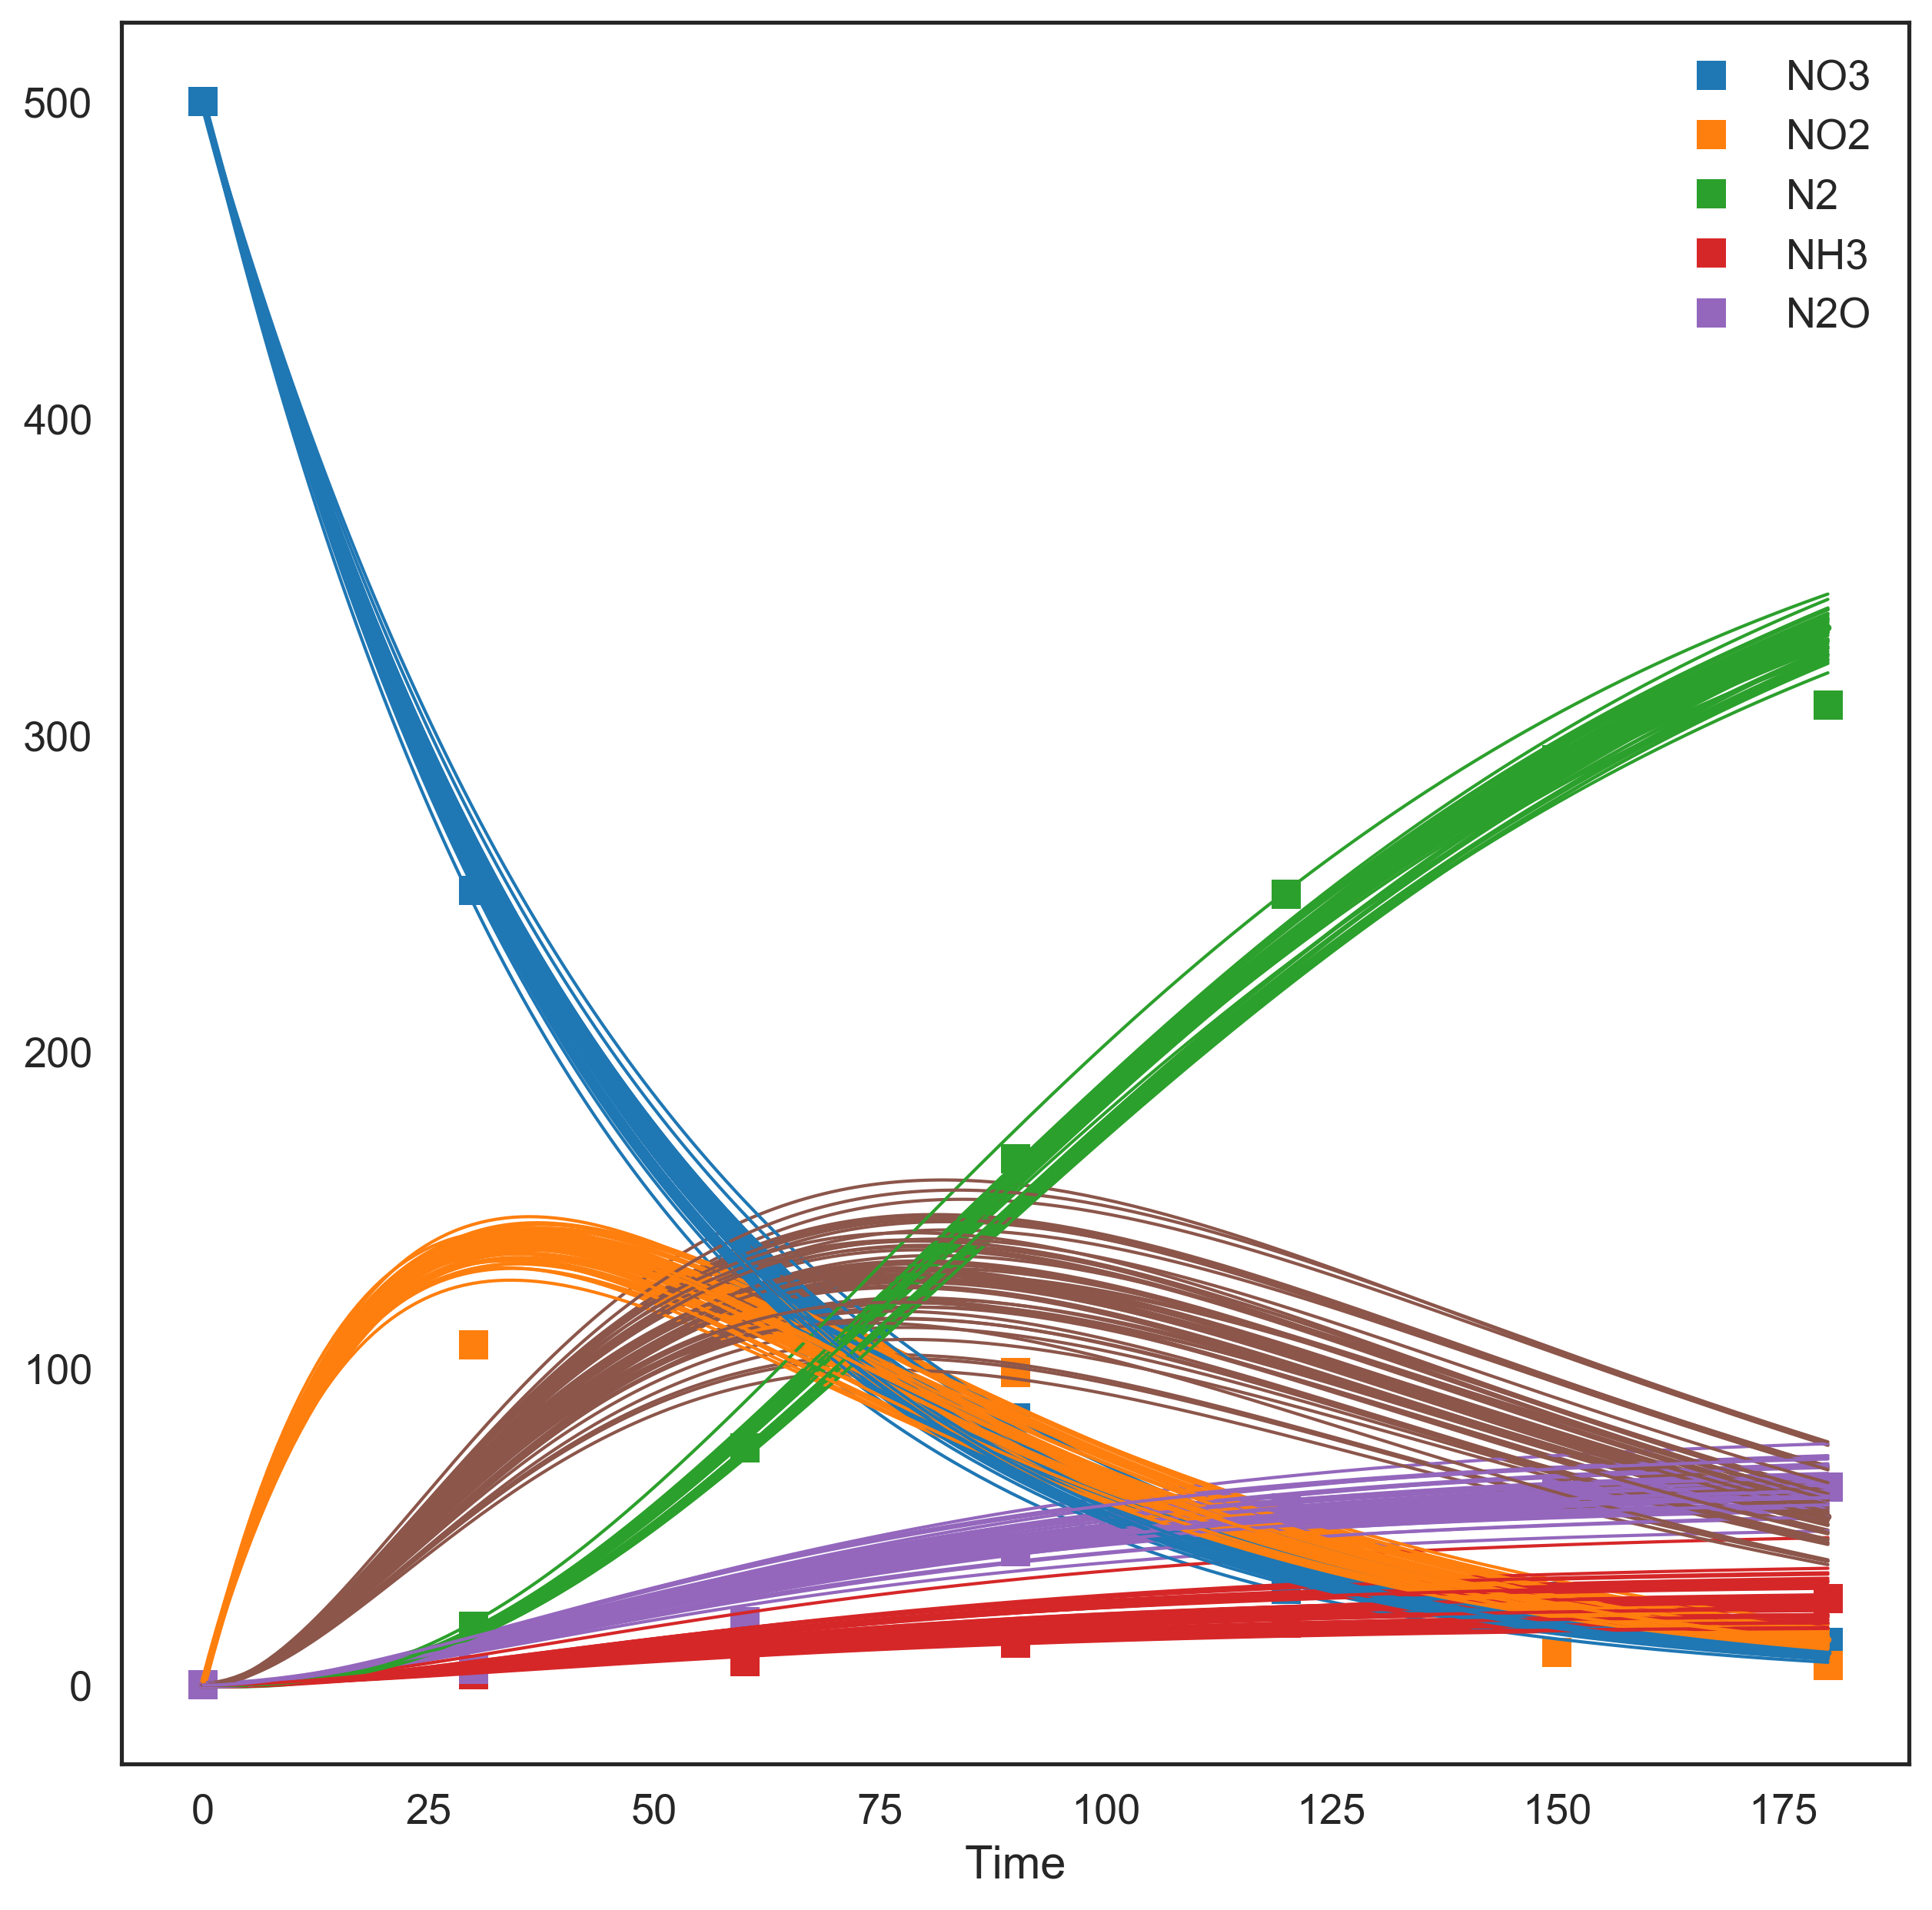

In [5]:
# Let's visualize the uncertainty about the response by taking some samples
num_samples = 50
t = np.linspace(0, 180, 200)

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
catalysis_data.plot(ax=ax, style='s')
Yp = Z(mu, t)
ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], label='Model X')
ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], label='Model N2O')
for i in range(num_samples):
    # Take a sample from the posterior
    x = np.random.multivariate_normal(mu, Sigma)
    Yp = Z(x, t)
    ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], lw=1, label='Model NO3-')
    ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], lw=1, label='Model NO2-')
    ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], lw=1, label='Model X')
    ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], lw=1, label='Model N2')
    ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], lw=1, label='Model NH3')
    ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], lw=1, label='Model N2O')

### Questions
+ Investigate what happens as you go from a very large $\sigma$ (say $20$) to a very small one (say $1$.) Is there a sweet spot?

+ Investigate what happens as you change $\gamma$ in the same way.

+ How elese can you propagate uncertainty through the solver?

## Estimating the Noise Level with the Laplace Approximation

We can estiamte the noise level with the Laplace approximation.
We need a prior on $\sigma$.
Let's pick:
$$
p(\sigma) \propto \frac{1}{\sigma}.
$$
This is known as the [Jeffrey's prior](https://en.wikipedia.org/wiki/Jeffreys_prior).

Also, because of the nature of the parameterization, it probably makes sense to work with $\log \sigma$ instead of $\sigma$.
So, let's introduce the following unknown vector to be inferred from the data:
$$
z = (x, \theta),
$$
where
$$
\theta = \log\sigma.
$$

### Be careful when you change variables
We need to be a little bit careful with $p(\theta)$.
We need to use the [change of variables formula](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables).
Define:
$$
\theta := g(\sigma) = \log \sigma.
$$
The inverse is:
$$
g^{-1}(\theta) = e^{\theta}.
$$
The formula is:
$$
p(\theta) = \left|\frac{d}{d\theta}\left(g^{-1}(\theta)\right)\right|\cdot p(\sigma=e^{\theta}) \propto e^\theta e^{-\theta} = 1.
$$
So
$$
p(\theta) \propto 1.
$$

Now, we just derive the posterior of $z$:
$$
p(z|y) \propto p(y|z)p(z) \propto e^{-m\theta}\exp\left\{-\frac{\parallel y - f(x) \parallel_2^2}{2e^{2\theta}}\right\}p(x),
$$
and we apply the Laplace approximation using:
$$
L(z) = -m\theta - \frac{\parallel y - f(x) \parallel_2^2}{2}e^{-2\theta} + \log p(x).
$$
The first and second mixed derivative with respect to $x$ are just like before.
We need the derivatives with respect to $\theta$:
$$
\frac{\partial L(z)}{\partial \theta} = -m + \parallel y - f(x) \parallel_2^2e^{-2\theta},
$$
$$
\frac{\partial^2 L(z)}{\partial \theta^2} = -2\parallel y - f(x) \parallel_2^2e^{-2\theta},
$$
and
$$
\frac{\partial^2 L(z)}{\partial x_j\partial\theta} = 2e^{-2\theta}\sum_{i=1}^m(y_i-f_i(x))\frac{\partial f_i(x)}{\partial x_j}.
$$

In [6]:
# The function that we need to maximize
def minus_log_post_w_noise(z, y, gamma):
    m = y.shape[0]
    x = z[:5]
    theta = z[5]
    sigma = np.exp(theta)
    k = np.exp(x) / 180.
    sol = solver(k)
    f = sol['f'][0][5:]
    dfdk = sol['f_grad'][0][5:, :]
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (y - f)
    dLdx = -np.einsum('ij,i->j', dfdx, tmp) / sigma ** 2 + x / gamma ** 2
    dLdtheta = m - np.sum(tmp ** 2) / sigma ** 2
    L = m * theta + 0.5 * np.sum(tmp ** 2) / sigma ** 2 + 0.5 * np.sum(x ** 2) / gamma ** 2
    dLdz = np.hstack([dLdx, [dLdtheta]])
    return L, dLdz


# The inverse of the second derivative
def compute_post_cov_w_noise(mu, y, gamma):
    m = y.shape[0]
    mu_x = mu[:5]
    sigma = np.exp(mu[5])
    k = np.exp(mu_x) / 180.
    sol = solver(k)
    f = sol['f'][0][5:]
    dfdk = sol['f_grad'][0][5:, :]
    d2fdk2 = sol['f_grad_2'][0][5:, :, :]
    # Chain rule
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    # Chain rule
    d2fdx2 = np.einsum('ijr,j,r->ijr', d2fdk2, k, k) + \
        np.einsum('ij,j,jr->ijr', dfdk, k, np.eye(k.shape[0]))
    tmp = (y - f)
    d2Ldx2 = - np.einsum('i,ijr->jr', tmp, d2fdx2) / sigma ** 2 \
             + np.einsum('ij,ir->jr', dfdx, dfdx) / sigma ** 2  \
             + np.eye(mu_x.shape[0]) / gamma ** 2
    d2Ldxdtheta = 2 * np.einsum('i,ij->j', tmp, dfdx) / sigma ** 2
    d2Ldtheta2 = 2 * np.sum(tmp ** 2) / sigma ** 2
    Lam = np.bmat([[d2Ldx2, d2Ldxdtheta[:, None]], [d2Ldxdtheta[None, :], [[d2Ldtheta2]]]])
    # We need to invert this to see our Sigma:
    Sigma = np.linalg.inv(Lam) # We should not ever invert - but we make an exception here
    return Sigma

In [7]:
# gamma choice
gamma = 10.

# Initial guess for x
z0 = np.random.randn(6)
z0[-1] = 10.

# Minimize the loss function
res = scipy.optimize.minimize(minus_log_post_w_noise, z0, jac=True, args=(y, gamma))

# The mean of the x's:
mu = res.x

# The covariance matrix of the x's:
Sigma = compute_post_cov_w_noise(mu, y, gamma)

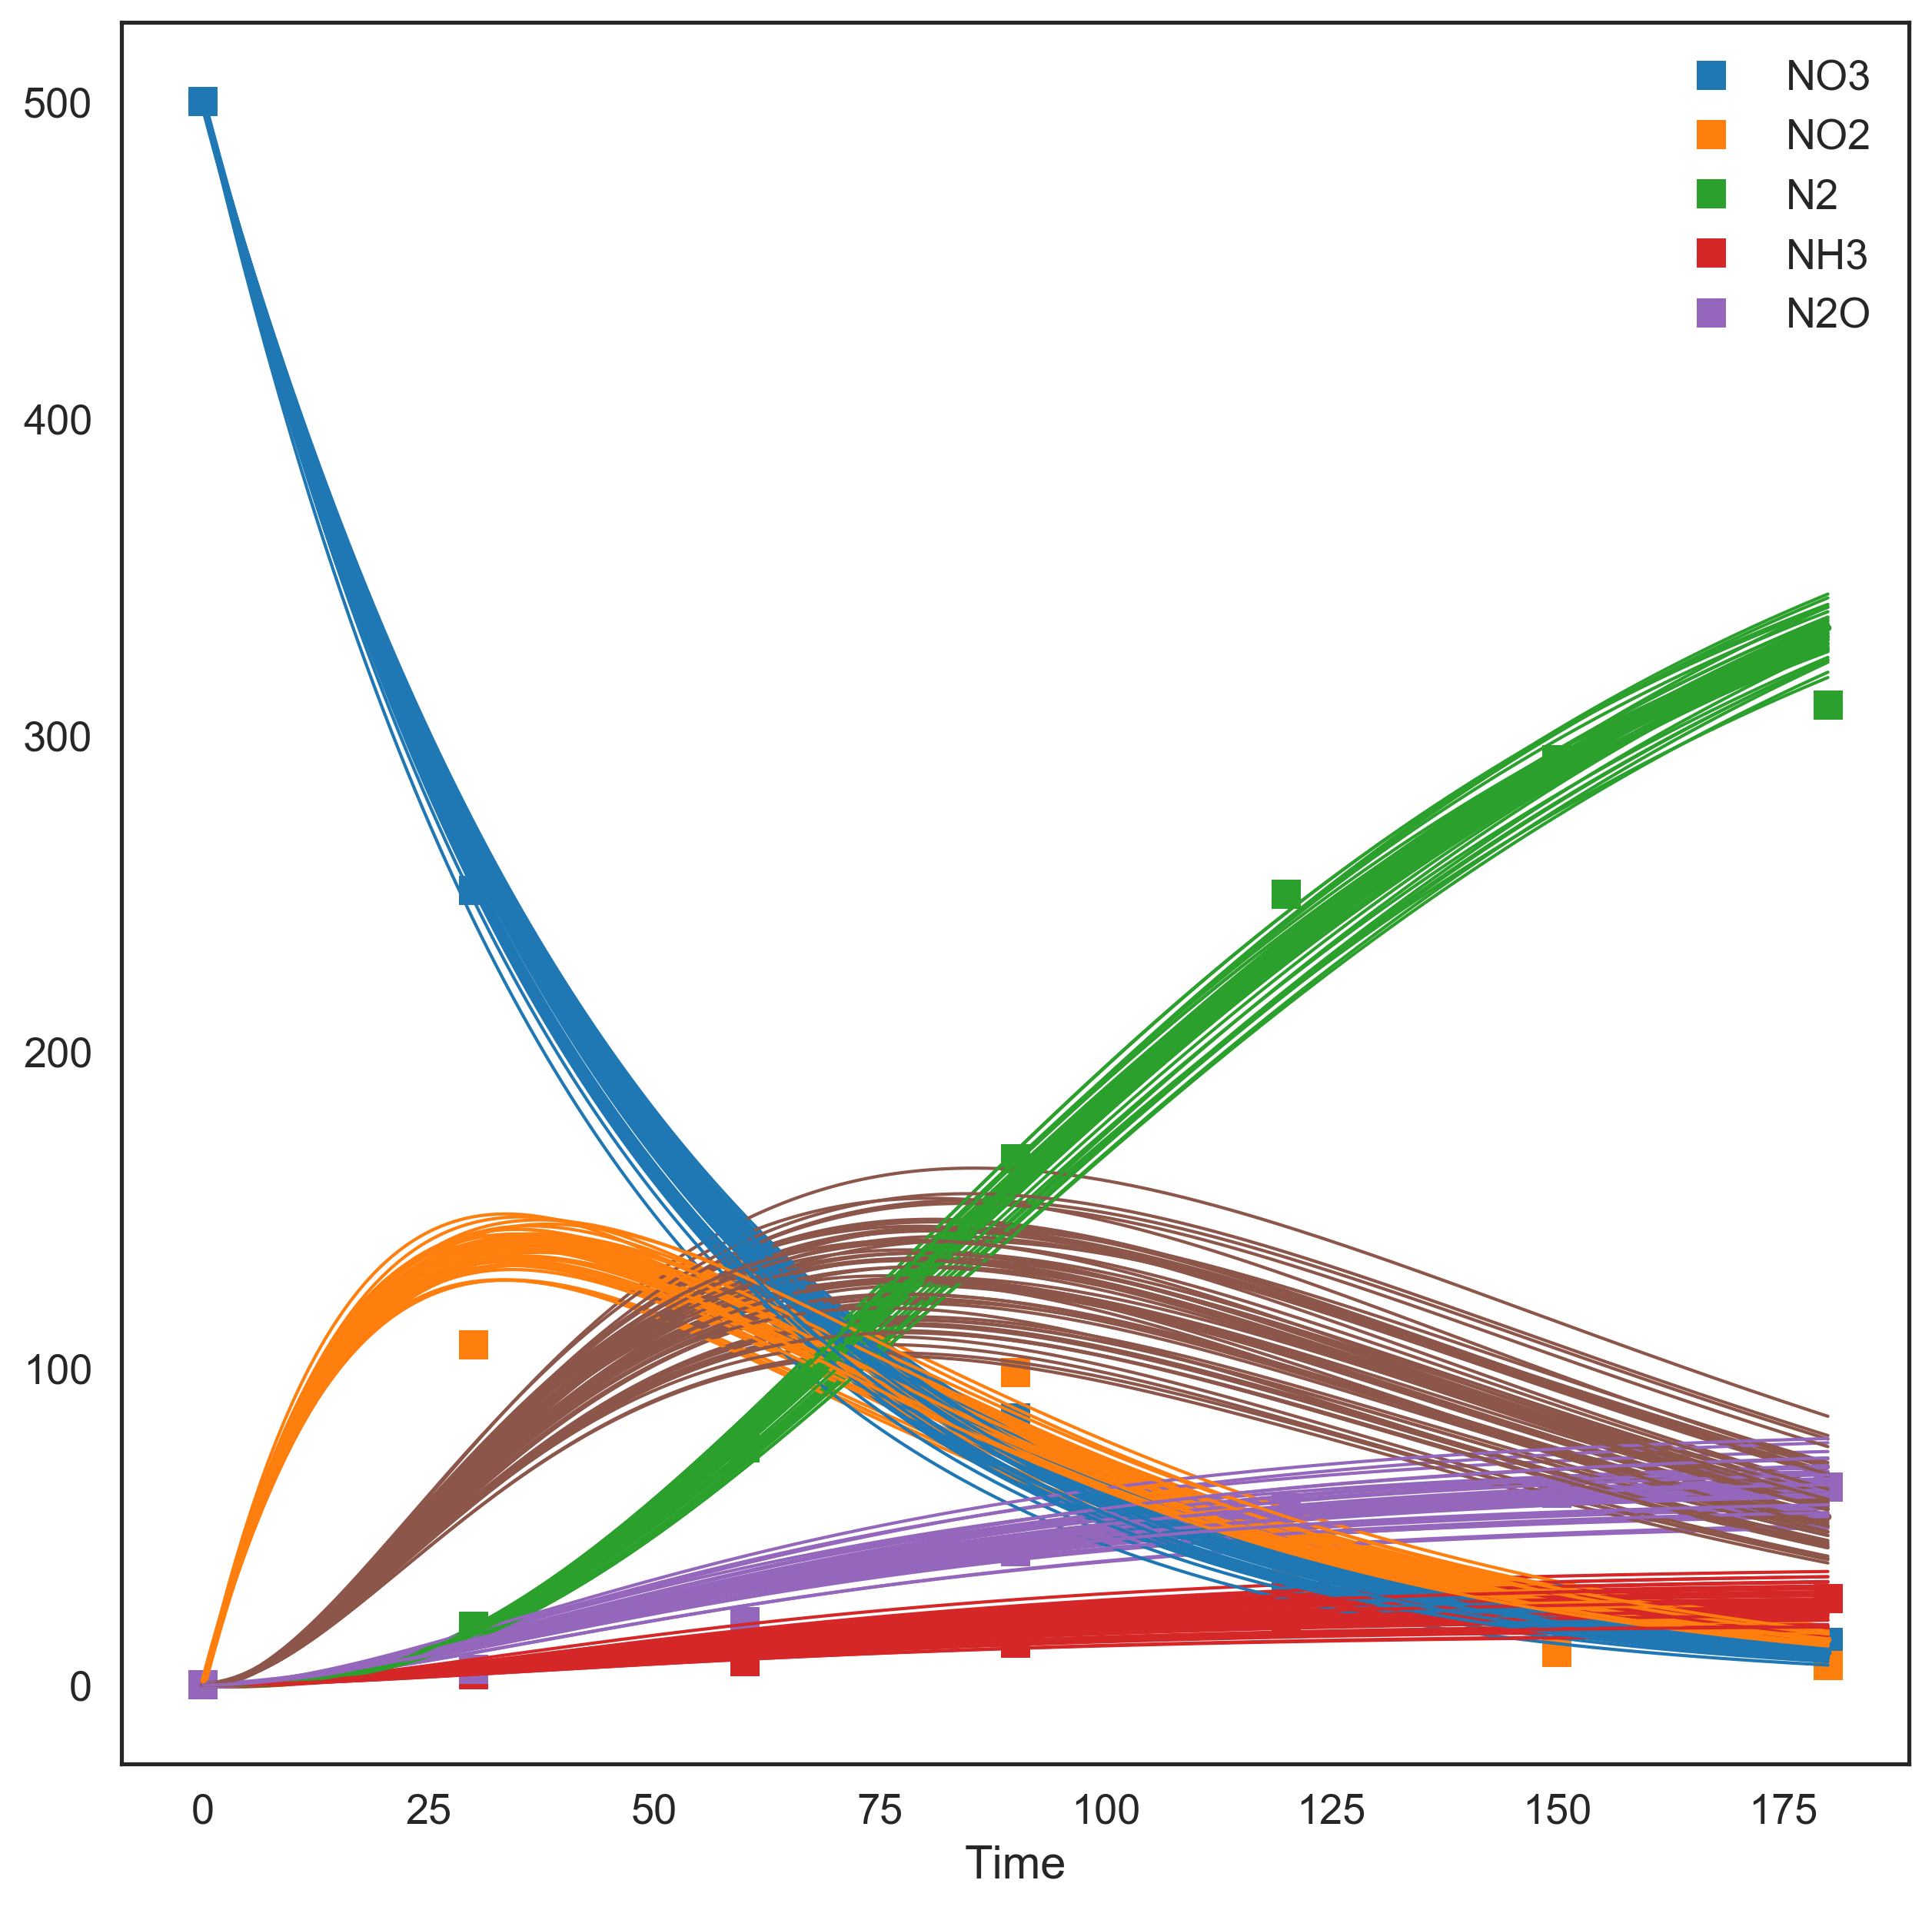

In [8]:
# Let's visualize the uncertainty about the response by taking some samples
num_samples = 50
t = np.linspace(0, 180, 200)

# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
catalysis_data.plot(ax=ax, style='s')
Yp = Z(mu[:5], t)
ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], label='Model X')
ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], label='Model N2O')
for i in range(num_samples):
    # Take a sample from the posterior
    x = np.random.multivariate_normal(mu, Sigma)
    Yp = Z(x[:5], t)
    ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], lw=1, label='Model NO3-')
    ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], lw=1, label='Model NO2-')
    ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], lw=1, label='Model X')
    ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], lw=1, label='Model N2')
    ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], lw=1, label='Model NH3')
    ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], lw=1, label='Model N2O')

In [9]:
# The sigma we found is:
sigma = np.exp(mu[5])
print sigma, '+-', 2. * np.sqrt(Sigma[-1, -1])

11.1158026142 +- 0.258197250197


### Questions
+ Investigate what happens as you change $\gamma$ from smaller to bigger values.

+ Is the uncertainty we visualized above epistemic or aleatory?

+ The uncertainty visualized concerns only the model. What if you wanted to include the measurement noise in this visualization?

+ The assumption of Gaussian noise is not very good. Generate two different assumptions that you could try for the noise.